In the following notebook I compare various implementations of FFT packages. Mainly, I'll have a look at Numpy and [pyFFTW](http://hgomersall.github.io/pyFFTW/index.html). Have a look at the documentation page for further details. Scipy's fftpack 'packs' the returned array so it is purely `real`, this is unfavourable in my opinion and I will therefore not consider it for the purpose of this comparison.

In [1]:
import numpy as np
import pyfftw

from time import time
import matplotlib.pyplot as plt

Lets generate a $2^{17}$ samples random signal:

In [2]:
n = 2**17
print n
a = np.random.rand(n)

131072


and compute the real FFT using Numpy's [rfft()](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.fft.rfft.html)

In [3]:
%%timeit
np.fft.rfft(a)

100 loops, best of 3: 1.87 ms per loop


Now lets test the FFTW interface to Numpy's [rfft()](http://hgomersall.github.io/pyFFTW/pyfftw/interfaces/numpy_fft.html#pyfftw.interfaces.numpy_fft.rfft):

* But first we will empty the cached FFT objects by invoking:

In [4]:
pyfftw.forget_wisdom()

In [5]:
%%timeit
pyfftw.interfaces.numpy_fft.rfft(a)

The slowest run took 715.47 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 3.93 ms per loop


We actually experience a performance hit relative to Numpy's fft which is surprising. Also note that the first time you call this function there is a huge overhead as the pyFFTW object is generated. This overhead gets smaller after the first time but never goes away completely.

In [6]:
%%timeit
pyfftw.interfaces.numpy_fft.rfft(a)

100 loops, best of 3: 3.48 ms per loop


And of course results are the same...

In [7]:
fft_np = np.fft.rfft(a)
fftw_np = pyfftw.interfaces.numpy_fft.rfft(a)
np.allclose(fft_np, fftw_np)

True

To implement pyFFTW's workhorse [FFTW](http://hgomersall.github.io/pyFFTW/pyfftw/pyfftw.html#fftw-class), we define a convenient wrapper that generates the FFTW object. To generate this object, an `input_array` and `output_array` must be allocated acording to the following scheme:


| Type     | ``input_array.dtype`` | ``output_array.dtype`` | Direction |
|:-------- |:--------------------- |:---------------------- |:--------- |
| Complex  | ``complex64``         | ``complex64``          | Both      |
| Complex  | ``complex128``        | ``complex128``         | Both      |
| Complex  | ``clongdouble``       | ``clongdouble``        | Both      |
| Real     | ``float32``           | ``complex64``          | Forwards  |
| Real     | ``float64``           | ``complex128``         | Forwards  |
| Real     | ``longdouble``        | ``clongdouble``        | Forwards  |
| Real     | ``complex64``         | ``float32``            | Backwards |
| Real     | ``complex128``        | ``float64``            | Backwards |
| Real     | ``clongdouble``       | ``longdouble``         | Backwards |
* see the documentation for further details.

The returned FFT object has an `input_array` variable that can be updated to contain the values of the signal being transformed. The fft itself is performed when the object is called.

In [8]:
def rfftw(x, **kwargs):
    input_array = np.empty(x.size, np.float64)
    output_array = np.empty(input_array.size // 2 + 1,
                            np.complex128)
    return pyfftw.FFTW(input_array, output_array, **kwargs)

* To be sure we are not using the cached FFT object from previously, lets empty the cached FFT objects again:

In [9]:
pyfftw.forget_wisdom()

In [10]:
%%timeit
fft_o = rfftw(a)
fft_o.input_array[:] = a
fft_o()

The slowest run took 1279.24 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 2.27 ms per loop


There is no performance boost here either and there is an overhead the first time you generate the pyFFTW object but once the object is generated, it can be reused over and over by assigning new data to the object's `input_array` and calling it.

In [11]:
fft_o = rfftw(a)
fft_o.input_array[:] = a
fftw_obj = fft_o()
np.allclose(fft_np, fftw_obj)

True

In [12]:
%%timeit
fft_o.input_array[:] = a
fft_o()

1000 loops, best of 3: 579 µs per loop


Now we can see a significant performance boost of **x3** relative to Numpy's FFT.

Another advantage of the FFTW object is threading (although I am not quite sure yet how to predetermine the optimal number of threads...):

* The next cell was executed twice because the first time generates the objects in cache and the second time leverages the cached objects

powers : threads
[    8 :  1, 2, 3, 4, 5, 6, 7, 8, ]
[   10 :  1, 2, 3, 4, 5, 6, 7, 8, ]
[   16 :  1, 2, 3, 4, 5, 6, 7, 8, ]
[   20 :  1, 2, 3, 4, 5, 6, 7, 8, ]
[   22 :  1, 2, 3, 4, 5, 6, 7, 8, ]


(4.2989670311982249e-05, 0.24550788055276743)

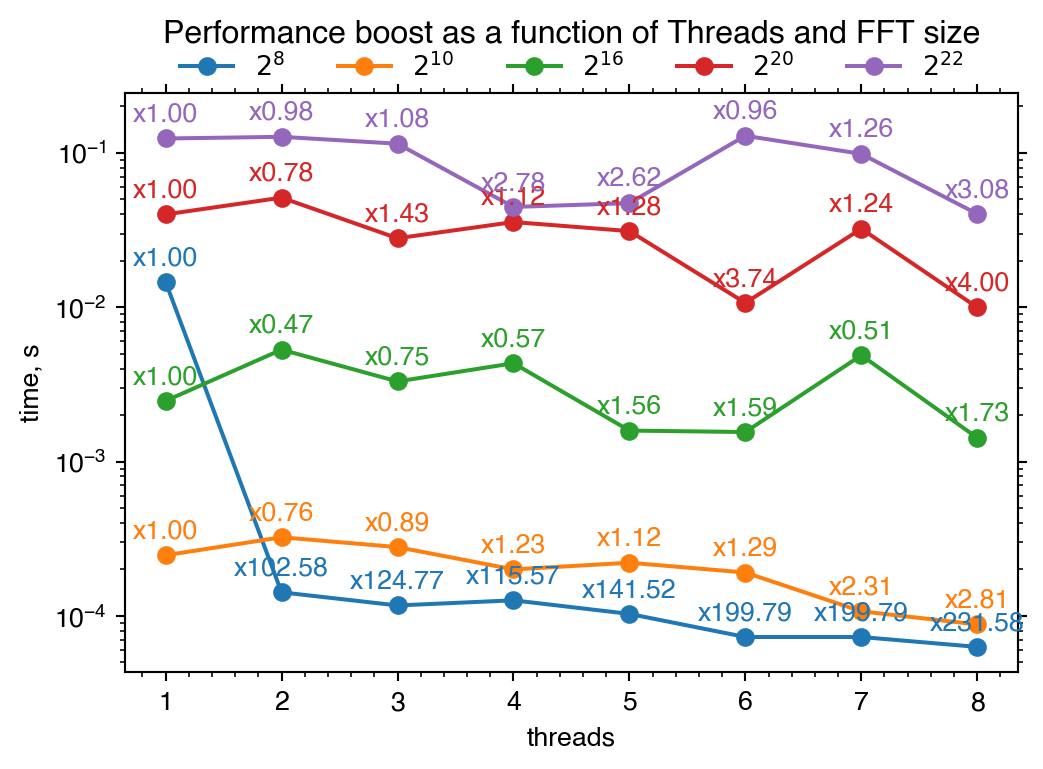

In [16]:
timing = []
boost = []
powers = (8, 10, 16, 20, 22)

print 'powers : threads'

for power in powers:
    print '[ {:>4d} : '.format(power),
    n = 2**power
    a = np.random.rand(n)
    
    timing_ = []
    boost_ = []
    t0 = time()
    fft_o = rfftw(a, threads=1)
    fft_o.input_array[:] = a
    fft_o()
    t1 = time() - t0

    timing_ += [t1]
    boost_ += [t1 / t1]
    print '{},'.format(1),

    for threads in range(2, 9):
        print '{},'.format(threads),
        t0 = time()
        fft_o = rfftw(a, threads=threads)
        fft_o.input_array[:] = a
        fft_o()
        t_final = time() - t0
        
        timing_ += [t_final]
        boost_ += [ t1 / t_final]
        
    timing += [timing_]
    boost += [boost_]
    
    print ']'

    l, = plt.plot(range(1,9), timing_, '-o', label='$2^{{{}}}$'.format(power))
    for i, t_final in enumerate(timing_):
        plt.text(i + 1 , t_final * 1.2, 'x{:.2f}'.format(t1 / t_final),
                 ha='center', va='bottom', color=l.get_c())
    
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.98),
           ncol=6, frameon=False)

plt.xlabel('threads')
plt.ylabel('time, s')
plt.title('Performance boost as a function of Threads and FFT size', y=1.06)

plt.yscale('log')

ymin, ymax = plt.ylim()
ymax *= 1.3
plt.ylim(ymin, ymax)

Seems that 1024 ($2^{10}$) samples, orange in the above example, is overall the most stable and relatively efficient. 256 (blue line), performs badly on one thread but gets a significant performance boost with threading.

All this could be different on different system setups...

Testing different FFT sizes with 6 threads:

|-----------|-----------|------------------|------------------|-------|
|     n     |  np rfft  |    fftw i np     |    rfftw obj     | equal | 
|-----------|-----------|------------------|------------------|-------|
|       256 | 3.149e-03 | 2.328e-03 [x1.4] | 6.962e-03 [x0.5] | True  |
|-----------|-----------|------------------|------------------|-------|
|       512 | 2.859e-04 | 2.532e-04 [x1.1] | 1.130e-04 [x2.5] | True  |
|-----------|-----------|------------------|------------------|-------|
|      1024 | 1.080e-04 | 2.398e-04 [x0.5] | 7.415e-05 [x1.5] | True  |
|-----------|-----------|------------------|------------------|-------|
|      2048 | 1.280e-04 | 3.181e-04 [x0.4] | 1.841e-04 [x0.7] | True  |
|-----------|-----------|------------------|------------------|-------|
|      4096 | 1.419e-04 | 4.809e-04 [x0.3] | 2.251e-04 [x0.6] | True  |
|-----------|-----------|------------------|------------------|-------|
|      8192 | 1.628e-04 | 4.900e-04 [x0.3] | 2.449e-04 [x0.7] |

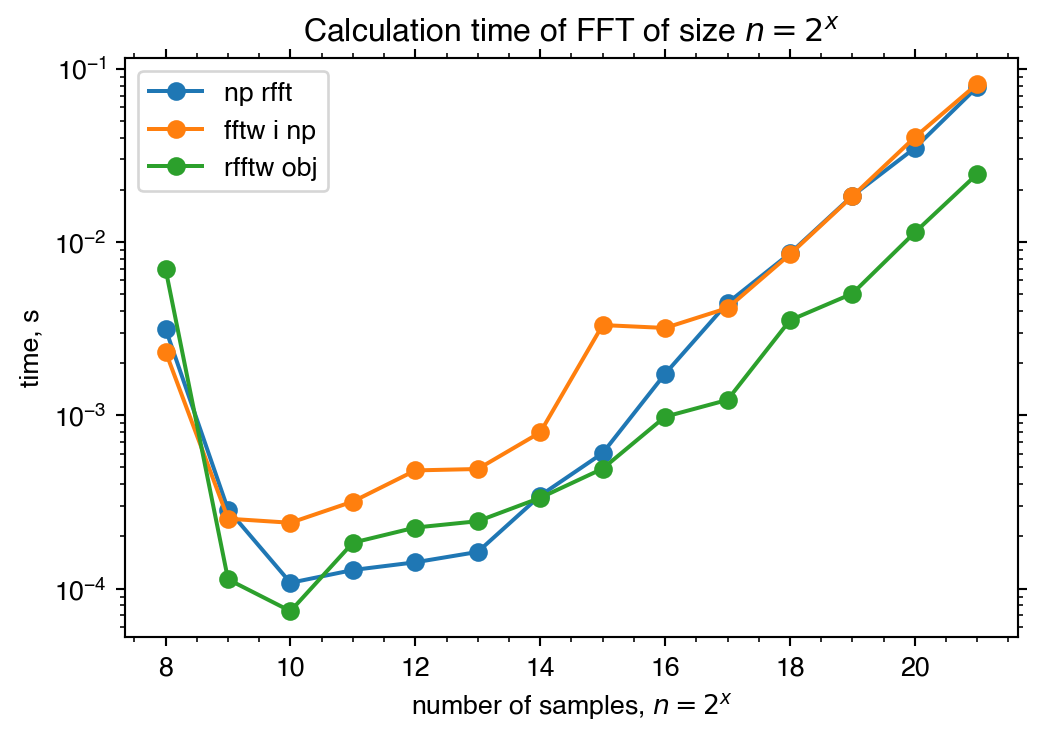

In [18]:
pyfftw.interfaces.cache.enable()
powers = range(8, 22)
threads = 6

print('|{:->11}|{:->11}|{:->18}|{:->18}|{:->7}|\n'
      '| {:^9} | {:^9} | {:^16} | {:^16} | {:^5} | \n'
      '|{:->11}|{:->11}|{:->18}|{:->18}|{:->7}|'.format(
          '', '', '', '', '',
          'n', 'np rfft', 'fftw i np', 'rfftw obj', 'equal',
          '', '', '', '', ''))
t = []
for power in powers:
    n = 2**power
    a = np.random.rand(n)
    t0 = time()
    fft_np = np.fft.rfft(a)
    t_np = time() - t0
    
    t0 = time()
    fft_interface = pyfftw.interfaces.numpy_fft.rfft(a, threads=threads)
    t_fftw_np = time() - t0
    
    t0 = time()
    fft_o = rfftw(a, threads=threads)
    fft_o.input_array[:] = a
    rfftw_result = fft_o()
    t_rfftw = time() - t0
    
    all_equal = (np.allclose(fft_np, fft_interface) ==
                 np.allclose(fft_np, rfftw_result) == True)
    
    print('| {:>9} | {:>6.3e} | {:>6.3e} [x{:.1f}] | {:>6.3e} [x{:.1f}] '
          '| {:^5} |\n'
          '|{:->11}|{:->11}|{:->18}|{:->18}|{:->7}|'.format(
              n, t_np, t_fftw_np, t_np / t_fftw_np, t_rfftw, t_np / t_rfftw,
              str(all_equal), '', '', '', '', ''))
    
    t += [[t_np, t_fftw_np, t_rfftw]]
    
plt.plot(powers, t, '-o')
plt.legend(('np rfft', 'fftw i np', 'rfftw obj'), loc=0)

plt.xlabel('number of samples, $n=2^x$')
plt.ylabel('time, s')
plt.title('Calculation time of FFT of size $n=2^x$')

plt.yscale('log')

and for a more realistic test, lets look at 10000 windows of random data:

|-----------|-----------|------------------|------------------|
|     n     |  np rfft  |    fftw i np     |    rfftw obj     |
|-----------|-----------|------------------|------------------|
|       256 | 3.564e-01 | 1.926e-01 [x1.9] | 5.506e-02 [x6.5] |
|-----------|-----------|------------------|------------------|
|       512 | 3.860e-01 | 3.500e-01 [x1.1] | 1.772e-01 [x2.2] |
|-----------|-----------|------------------|------------------|
|      1024 | 5.000e-01 | 2.921e-01 [x1.7] | 1.642e-01 [x3.0] |
|-----------|-----------|------------------|------------------|
|      2048 | 6.935e-01 | 6.478e-01 [x1.1] | 4.757e-01 [x1.5] |
|-----------|-----------|------------------|------------------|
|      4096 | 1.069e+00 | 9.260e-01 [x1.2] | 7.404e-01 [x1.4] |
|-----------|-----------|------------------|------------------|
|      8192 | 1.979e+00 | 1.464e+00 [x1.4] | 1.299e+00 [x1.5] |
|-----------|-----------|------------------|------------------|
|     16384 | 3.727e+00 | 2.726e+00 [x1.

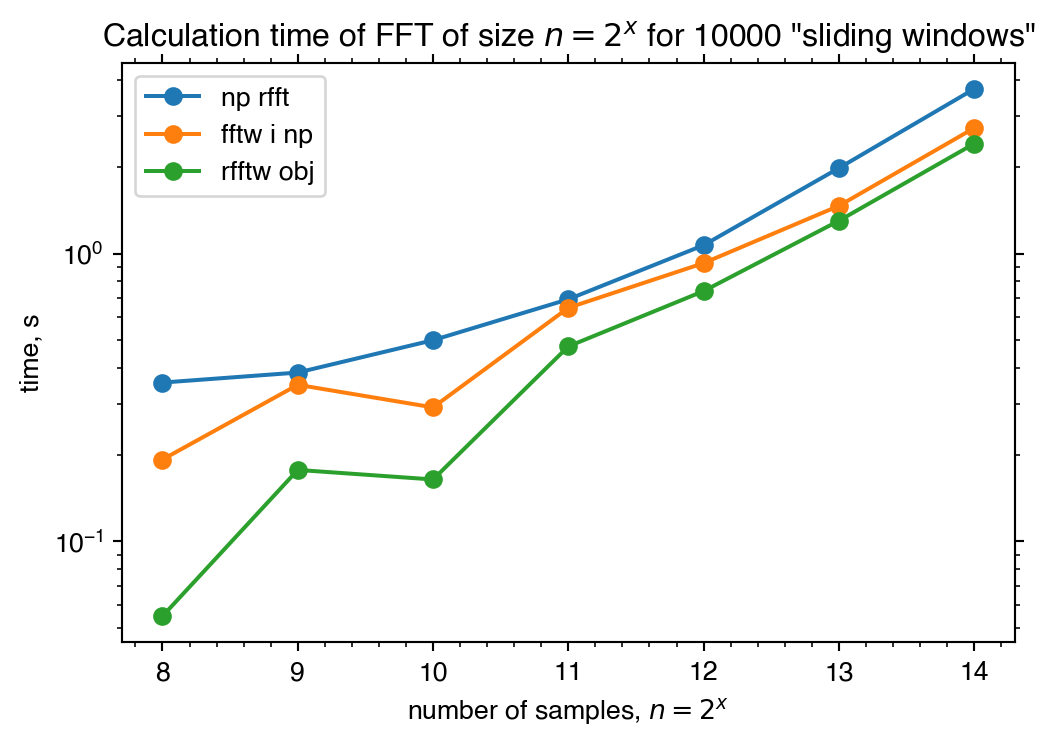

In [20]:
pyfftw.interfaces.cache.enable()
powers = range(8, 15)
windows = 10000
threads = 6

print('|{:->11}|{:->11}|{:->18}|{:->18}|\n'
      '| {:^9} | {:^9} | {:^16} | {:^16} |\n'
      '|{:->11}|{:->11}|{:->18}|{:->18}|'.format(
          '', '', '', '',
          'n', 'np rfft', 'fftw i np', 'rfftw obj',
          '', '', '', ''))
t = []
for power in powers:
    n = 2**power
    
    t0 = time()
    for i in range(windows):
        np.fft.rfft(np.random.rand(n))
    t_np = time() - t0
    
    t0 = time()
    for i in range(windows):
        pyfftw.interfaces.numpy_fft.rfft(np.random.rand(n), threads=threads)
    t_fftw_np = time() - t0
    
    t0 = time()
    fft_o = rfftw(np.empty(n), threads=threads)
    for i in range(windows):
        fft_o.input_array[:] = np.random.rand(n)
        fft_o()
    t_rfftw = time() - t0
    
    print('| {:>9} | {:>6.3e} | {:>6.3e} [x{:.1f}] | {:>6.3e} [x{:.1f}] |\n'
          '|{:->11}|{:->11}|{:->18}|{:->18}|'.format(
              n, t_np, t_fftw_np, t_np / t_fftw_np, t_rfftw, t_np / t_rfftw,
              '', '', '', ''))
    
    t += [[t_np, t_fftw_np, t_rfftw]]
    
plt.plot(powers, t, '-o')
plt.legend(('np rfft', 'fftw i np', 'rfftw obj'), loc=0)

plt.xlabel('number of samples, $n=2^x$')
plt.ylabel('time, s')
plt.title('Calculation time of FFT of size $n=2^x$ for 10000 "sliding windows"')

plt.yscale('log')

Note that for large size FFTs, the difference becomes less significant but is still faster nonetheless.